# **Deep Research with Bing Search & Scraping**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow now includes a dedicated scraping phase for extracting and cleaning web content:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Web Content Scraping** - Extracting, cleaning, and filtering relevant content from web pages using a ScraperAgent
4. **Content Analysis** - Summarizing scraped results and extracting key insights
5. **Report Generation** - Creating detailed research reports with proper citations
6. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- WebScraperAgent - Extracts, cleans, and filters relevant content from web pages
- SummaryAgent - Extracts key insights from scraped content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
import os
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class ScrapedWebPage(BaseModel):
    url: str = Field(..., description="The original URL that was scraped")
    title: Optional[str] = Field(None, description="The page title (if available, else None)")
    main_content: Optional[str] = Field(None, description="The main textual content of the page, cleaned and potentially truncated (if available, else None)")
    source: Optional[str] = Field(None, description="The name of the source (if available, else None)")
    published_date: Optional[str] = Field(None, description="YYYY-MM-DD (if available, else None)")
    scrape_error: Optional[str] = Field(None, description="Error message if scraping failed, else None")
    # Fields below might be added by the agent based on instructions, not the tool directly
    extraction_method: Optional[str] = Field(None, description="How content was extracted (e.g., 'tool_extracted', 'agent_filtered')") 
    relevance_score_agent: Optional[float] = Field(None, description="Agent's assessment of relevance (0-10)")
    matched_sections: Optional[List[str]] = Field(None, description="Sections identified by the agent as relevant")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

The following cell will ***create*** an **Azure AI Agent**, so you only need to run this cell **once**.

In [5]:
from azure.ai.agents.models import BingGroundingTool

import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_connection = project_client.connections.get(
    name=os.getenv("BING_CONNECTION_NAME")
)

bing_tool = BingGroundingTool(connection_id=bing_connection.id)

bing_search_agent = project_client.agents.create_agent(
    name="bingSearchAgent",
    description="Agent to perform web searches using Bing.",
    model=os.getenv("chatModel"),
    temperature=0.5,
    tools=bing_tool.definitions,
    instructions=f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
    """.strip()
)

If you already have an Azure AI Agent, run this cell to update it's instructions with today's date.

In [6]:
import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))
bing_search_agent.instructions = f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
""".strip()

print(bing_search_agent.instructions)

You are a helpful research assistant.

Today's date is 2025-06-03.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.


**OpenAI Agents**

In [7]:
from agents import (
    Agent,
    ModelSettings
)

from common.utils_scraping import scrape_web_page

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions=f"""
    Today's date is {current_date}.

    You are an expert research planner specializing in creating detailed research plans your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 4 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 2 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """.strip(),
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

web_scraper_agent = Agent(
    name="WebScraperAgent",
    instructions=f"""
    Today's date is {current_date}.
    
    You are a robust, context-aware web scraping specialist. Your primary tool is 'scrape_web_page'.

    Your input is a JSON string containing: 'url', 'subtopic', 'user_query', 'search_result_title', 'visited_urls', and 'max_content_length'. Parse this JSON to get the necessary information.

    **Workflow:**
    1.  **Parse Input:** Extract 'url', 'user_query', 'subtopic', 'search_result_summary', and 'max_content_length' from the input JSON string.
    2.  **Call Scraping Tool:** Call the `scrape_web_page` tool with the 'url' and 'max_content_length'.
    3.  **Analyze Tool Output:** Receive the dictionary from the tool containing `url`, `title`, `main_content`, `source`, `published_date`, `scrape_error`.
    4.  **Contextual Filtering (If Content Exists and No Error):**
        - If `scrape_error` is None and `main_content` exists:
            - Review the `main_content`.
            - Use the `user_query`, `subtopic`, and `search_result_summary` to identify ONLY the most relevant paragraphs or sections.
            - If the entire `main_content` seems relevant or is short, keep it all.
            - If filtering, replace `main_content` with ONLY the relevant extracted parts. Set `extraction_method` to 'agent_filtered'.
            - Estimate a `relevance_score_agent` (0-10).
            - Optionally list `matched_sections`.
        - If `scrape_error` is present, ensure the `scrape_error` field in your output reflects the tool's error.
    5.  **Format Output:** Return a SINGLE JSON object matching the `ScrapedWebPage` Pydantic model, including all fields based on the tool's output and your filtering. If the tool failed, `main_content` should be None/empty, and `scrape_error` should be set.
    6.  **Return JSON object:** Return ONLY the final object formatted as a single, valid JSON. Do NOT add any explanatory text before or after the JSON.

    **Constraints:**
    - Your final output MUST be ONLY a valid JSON representing the scraped and processed data.
    - Adhere strictly to the field names defined in the conceptual `ScrapedWebPage` structure when creating the JSON.
    - Prioritize accuracy and relevance based on the provided context.
    """,
    model=chatModel,
    model_settings=chatModelSettings,
    tools=[scrape_web_page],
    output_type=ScrapedWebPage
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)


peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)

**hand-offs**

In [8]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Web Content Scraping** → WebScraperAgent extracts, cleans, and filters relevant content from web pages
5. **Analysis** → SummaryAgent processes scraped results, extracting key insights while preserving technical details
6. **Synthesis** → ResearchAgent creates well-structured report with proper citations
7. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
8. **Revision** → If needed, research report undergoes improvement cycles based on feedback
9. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

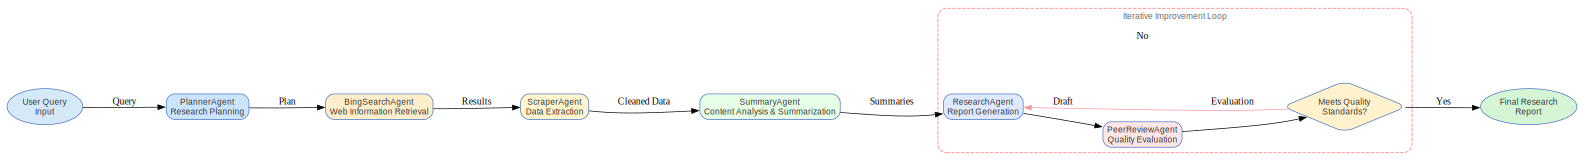

In [9]:
from common.helper import create_research_workflow_diagram_scraper

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram_scraper()
workflow_diagram

Let's start with a sample research query.

In [ ]:
# user_query="What big industries will AI have the most affect on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [11]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [12]:
plan.final_output.research_tasks[0].search_queries

['What is classical machine learning?',
 'What is deep learning?',
 'What is generative AI?',
 'Core principles of classical machine learning vs deep learning vs generative AI']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. Multiple search queries are sent to gather diverse perspectives.
2. The agent returns structured search results with titles, summaries, relevance scores, and URLs.
3. Results are organized by subtopic for further processing.

This step leverages Azure AI Projects with Bing Search integration to identify promising sources.

In [13]:
import os
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.threads.create()
            message = project_client.agents.messages.create(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.runs.create_and_process(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.threads.delete(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 4/4 [03:04<00:00, 46.02s/it]


In [14]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 17

Actually total search queries: 17



### Step 3: Web Content Scraping

The WebScraperAgent processes the URLs and metadata returned by the BingSearchAgent. For each subtopic:

1. Only URLs with a high enough relevance score are selected for scraping.
2. The WebScraperAgent visits each selected URL and extracts the most relevant content, guided by the user query, subtopic, and search result summary.
3. Extracted content is cleaned, deduplicated, and enriched with metadata such as title, source, published date, and extraction method.
4. The resulting structured data is organized by subtopic for downstream analysis and summarization.

This step ensures that only the most promising and contextually relevant web content is collected, providing a high-quality foundation for subsequent summarization and synthesis.

In [15]:
from typing import Set

class ScraperAgentInput(BaseModel):
    url: str
    subtopic: str
    user_query: str
    search_result_title: str
    visited_urls: Set[str] = Field(default_factory=set)
    max_content_length: int = 4000

In [16]:
# TODO: Implement a threshold for relevance score 

# --- Scraping Phase ---
urls_to_process_map = {}

print("Preparing scrape tasks...")
for subtopic_result in search_results:
    subtopic = subtopic_result["subtopic"]
    for query_result in subtopic_result["queries"]:
        query = query_result["query"]
        for result in query_result["results"]:
            if result["url"] not in urls_to_process_map:
            # if result.relevance_score >= MIN_RELEVANCE_SCORE and result.url not in urls_to_process_map:
                urls_to_process_map[result["url"]] = {
                    "subtopic": subtopic,
                    "query": query,
                    "search_result_title": result["title"]
                }

visited_urls_tracker = set(urls_to_process_map.keys())
print(f"Found {len(urls_to_process_map)} unique URLs above threshold to scrape.")

Preparing scrape tasks...
Found 24 unique URLs above threshold to scrape.


In [17]:
from itertools import islice

MAX_SCRAPE_CONTENT_LENGTH = 4000 # Max characters for scrape tool

scrape_tasks = []
num_urls_to_scrape = len(urls_to_process_map)

for url, context in tqdm(islice(urls_to_process_map.items(), num_urls_to_scrape),
                         desc="Preparing scrape tasks",
                         total=num_urls_to_scrape):
    agent_input_model = ScraperAgentInput(
        url=url,
        subtopic=context["subtopic"],
        user_query=context["query"],
        search_result_title=context["search_result_title"],
        visited_urls=visited_urls_tracker,
        max_content_length=MAX_SCRAPE_CONTENT_LENGTH
    )

    scrape_response = await Runner().run(
        starting_agent=web_scraper_agent,
        input=f"Scrape data from the provided URL: {agent_input_model.model_dump_json()}"
    )
    scrape_tasks.append(scrape_response.final_output)

Preparing scrape tasks: 100%|██████████| 24/24 [02:31<00:00,  6.30s/it]


### Step 4: Content Analysis and Summarization

For each scraped result, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the cleaned web content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms high-quality scraped data into structured, information-rich summaries that will form the basis of our research report.

In [18]:
from common.utils_summary import collect_contents_and_citations, summarize_content
summarize_per_webpage = False  # True will summarize per web page, False will summarize per subtopic

# Build a lookup for scraped content (using attribute access)
scraped_content_by_url = {
    item.url: item.main_content
    for item in scrape_tasks
    if getattr(item, "main_content", None)
}

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    contents, citations = collect_contents_and_citations(subtopic_result, scraped_content_by_url)
    summaries = await summarize_content(contents, summary_agent, Runner, summarize_per_webpage)
    if summarize_per_webpage:
        mapped_chunks.append({
            "subtopic": subtopic_result["subtopic"],
            "summaries": summaries,
            "citations": citations
        })
    else:
        mapped_chunks.append({
            "subtopic": subtopic_result["subtopic"],
            "summaries": summaries,
            "citations": citations
        })

# Filter out empty summaries
mapped_chunks = [c for c in mapped_chunks if c['summaries']]

Summarizing subtopics: 100%|██████████| 4/4 [00:48<00:00, 12.01s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [19]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [20]:
from agents import HandoffCallItem

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [21]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# Comparative Analysis of Classical Machine Learning, Deep Learning, and Generative AI: Definitions, Methodologies, Applications, Strengths, and Limitations

## Introduction

The field of artificial intelligence (AI) has undergone a remarkable evolution, progressing from rule-based expert systems to sophisticated neural networks capable of generating original content. This transformation is characterized by the emergence and interplay of three key paradigms: classical machine learning (ML), deep learning (DL), and generative AI (GenAI). Each paradigm represents a distinct approach to enabling machines to learn from data, solve complex problems, and, increasingly, create new content. As AI technologies become ever more integral to industry, research, and daily life, a nuanced understanding of their definitions, methodologies, applications, strengths, and limitations is essential. This report offers a comprehensive, in-depth comparison of classical machine learning, deep learning, and generative AI, synthesizing technical, practical, and ethical perspectives to illuminate their unique contributions and evolving relationships.

## 1. Definitions and Core Principles

### 1.1 Classical Machine Learning

Classical machine learning is a subset of artificial intelligence that focuses on algorithms enabling computers to learn from data and make predictions or decisions without being explicitly programmed for each task. At its core, classical ML relies on statistical methods to identify patterns in structured datasets, with the goal of generalizing from historical data to new, unseen examples. The learning process typically involves training a model on labeled data (supervised learning), unlabeled data (unsupervised learning), or a combination (semi-supervised learning), and then evaluating its performance on separate test data. Classical ML encompasses a range of algorithms, including linear regression, logistic regression, decision trees, support vector machines (SVMs), k-nearest neighbors, and clustering techniques such as k-means. These models are generally characterized by their reliance on explicit feature engineering, where domain experts manually select and transform input variables to optimize model performance. The success of classical ML is often contingent upon the quality of the features and the availability of labeled data, making it highly effective for structured data analysis but less suited to unstructured or high-dimensional data such as images or raw text [1][2].

### 1.2 Deep Learning

Deep learning represents a specialized branch of machine learning distinguished by its use of artificial neural networks with multiple layers—hence the term "deep." Inspired by the structure and function of the human brain, deep learning models automatically learn hierarchical representations of data, enabling them to extract complex features and model non-linear relationships. Unlike classical ML, deep learning minimizes the need for manual feature engineering by learning directly from raw data. The architecture of deep learning networks can vary, with common types including feedforward neural networks, convolutional neural networks (CNNs) for image processing, recurrent neural networks (RNNs) and long short-term memory networks (LSTMs) for sequential data, and transformer models for natural language processing. Deep learning excels at tasks involving unstructured or high-dimensional data, such as image and speech recognition, language translation, and autonomous driving. The depth and complexity of these models, however, necessitate large volumes of training data and significant computational resources, often leveraging specialized hardware such as graphics processing units (GPUs) [3][4].

### 1.3 Generative AI

Generative AI (GenAI) is a transformative subset of artificial intelligence focused on the autonomous creation of new, original content—text, images, audio, video, code, and more—by learning patterns from massive datasets. Unlike traditional AI, which primarily analyzes data to make predictions or decisions, generative AI models are designed to produce outputs that mimic or even surpass human creativity. At the heart of generative AI are advanced deep learning architectures, particularly large language models (LLMs), generative adversarial networks (GANs), and transformers, which are trained on vast, often unlabeled datasets. The generative AI development process typically unfolds in three phases: training a foundation model on massive datasets, fine-tuning for specific applications, and iterative generation and evaluation to refine output quality. Generative AI's flexibility, scalability, and ability to respond to natural language prompts have accelerated its adoption across industries, with applications ranging from content creation and research to design and automation [5][6][7].

### 1.4 Hierarchical Relationship

The relationship among these paradigms can be visualized as a nested hierarchy: AI encompasses all systems that mimic human intelligence, including machine learning (which enables systems to learn from data), deep learning (which uses multi-layer neural networks for complex pattern recognition), and generative AI (which leverages these advances to create new content). This hierarchy clarifies the progression from broad, rule-based systems to increasingly specialized and autonomous models.

#### Figure 1: Hierarchical Breakdown of AI Paradigms

| Level           | Description                                        | Examples                       |
|-----------------|----------------------------------------------------|--------------------------------|
| Artificial Intelligence (AI) | Systems mimicking human intelligence         | Expert systems, search engines |
| Machine Learning (ML)        | Algorithms learning from data                | SVM, decision trees            |
| Deep Learning (DL)           | Multi-layered neural networks                | CNNs, RNNs, LSTMs              |
| Generative AI (GenAI)        | Content-creating models using DL architectures | GPT, DALL-E, GANs              |

## 2. Methodologies and Architectures

### 2.1 Classical Machine Learning Methodologies

Classical machine learning methodologies are grounded in statistical learning theory and rely heavily on structured data and explicit feature engineering. The primary learning paradigms include supervised learning, where models are trained on labeled data to perform classification or regression; unsupervised learning, which seeks to uncover hidden structures in unlabeled data through clustering or dimensionality reduction; semi-supervised learning, which combines labeled and unlabeled data to improve performance in scenarios with limited annotations; and reinforcement learning, where agents learn optimal actions through trial and error in dynamic environments. Classical ML workflows typically involve data collection, preprocessing, feature selection and extraction, model selection, training, evaluation, and deployment. Overfitting—where a model performs well on training data but poorly on new data—is a persistent challenge, addressed through techniques such as regularization, cross-validation, and pruning in tree-based models. The effectiveness of classical ML is often constrained by the need for high-quality labeled data and the expertise required for feature engineering [1][2][8].

### 2.2 Deep Learning Architectures

Deep learning methodologies depart from the explicit feature engineering of classical ML by leveraging artificial neural networks with multiple layers. The fundamental unit of a neural network is the neuron, which processes input data through weighted connections and non-linear activation functions. Deep learning models are characterized by their depth—the number of hidden layers—which enables them to learn increasingly abstract representations of data. Key architectures include:

- **Feedforward Neural Networks:** The simplest form, where data flows in one direction from input to output.
- **Convolutional Neural Networks (CNNs):** Specialized for image and spatial data, CNNs use convolutional layers to automatically extract spatial hierarchies of features.
- **Recurrent Neural Networks (RNNs) and LSTMs:** Designed for sequential data, RNNs maintain internal memory to capture temporal dependencies, while LSTMs address the vanishing gradient problem in long sequences.
- **Transformers:** Introduced for natural language processing, transformers use attention mechanisms to model relationships within sequential data, enabling parallel processing and improved performance on tasks such as language translation and text generation.

Deep learning models are typically trained using large-scale datasets and require significant computational resources. The automatic feature extraction capabilities of DL have made it the architecture of choice for tasks involving unstructured data, such as image classification, speech recognition, and natural language understanding [3][4][9].

### 2.3 Generative AI Methodologies

Generative AI builds upon deep learning architectures to enable the creation of new content. The most prominent methodologies include:

- **Large Language Models (LLMs):** Transformer-based models like GPT-3 and GPT-4 are trained on massive corpora of text, learning to generate coherent and contextually relevant language. These models use attention mechanisms to capture relationships within and across sentences, enabling nuanced language generation.
- **Generative Adversarial Networks (GANs):** Consist of two neural networks—a generator and a discriminator—that compete in a zero-sum game. The generator creates synthetic data, while the discriminator evaluates its authenticity, driving the generator to produce increasingly realistic outputs. GANs are particularly effective for image, audio, and video synthesis.
- **Variational Autoencoders (VAEs):** Probabilistic models that learn to encode data into a latent space and generate new samples by decoding from this space, useful for data synthesis and anomaly detection.
- **Multimodal Large Language Models (MLLMs):** Extend the capabilities of LLMs to process and generate content across multiple modalities, such as text, images, audio, and video.

The generative AI development process involves training foundation models on vast, often unlabeled datasets, fine-tuning for specific applications, and iterative evaluation and improvement. Recent advances such as Multimodal Retrieval-Augmented Generation (MM-RAG) further enhance generative AI by integrating multiple data modalities, improving contextual understanding and response accuracy [5][6][10].

#### Figure 2: Comparison Table of Methodologies and Architectures

| Paradigm        | Key Methodologies           | Typical Architectures                | Data Requirements      |
|-----------------|----------------------------|--------------------------------------|-----------------------|
| Classical ML    | Supervised, unsupervised, reinforcement | Decision trees, SVMs, k-means        | Labeled, structured   |
| Deep Learning   | Supervised, unsupervised   | CNNs, RNNs, LSTMs, transformers      | Large, unstructured   |
| Generative AI   | Unsupervised, semi-supervised, adversarial | LLMs, GANs, VAEs, MLLMs              | Massive, unlabeled    |

## 3. Applications and Use Cases

### 3.1 Classical Machine Learning Applications

Classical machine learning has been foundational in a wide array of applications, particularly where structured data and explicit feature engineering are feasible. Notable use cases include:

- **Fraud Detection:** ML algorithms analyze transaction patterns to identify anomalous behavior indicative of fraud in banking and finance.
- **Medical Diagnosis:** Decision trees and support vector machines assist in diagnosing diseases based on patient data, improving accuracy and efficiency.
- **Sentiment Analysis:** Text classification models assess customer feedback or social media posts to gauge public sentiment.
- **Image and Video Recognition:** Early computer vision applications used classical ML for object detection and facial recognition, though these have largely been superseded by deep learning.
- **Data Mining:** Unsupervised learning techniques uncover hidden patterns and associations in large datasets, supporting business intelligence and market analysis.

Despite their impact, classical ML models often struggle with high-dimensional or unstructured data, limiting their applicability in domains such as raw image or audio processing [1][2][11].

### 3.2 Deep Learning Applications

Deep learning has revolutionized fields that require the analysis of unstructured or high-dimensional data. Its automatic feature extraction and hierarchical representation learning have enabled breakthroughs in:

- **Image Recognition:** CNNs power state-of-the-art systems for object detection, facial recognition, and medical imaging analysis.
- **Speech Recognition:** RNNs and LSTMs facilitate accurate transcription and voice-controlled interfaces.
- **Natural Language Processing (NLP):** Transformers and LSTMs underpin applications such as language translation, sentiment analysis, and question answering.
- **Autonomous Vehicles:** Deep learning models process sensor data to enable real-time perception, decision-making, and control in self-driving cars.
- **Recommendation Systems:** DL architectures analyze user behavior and preferences to deliver personalized content in e-commerce and streaming platforms.

The success of deep learning in these domains is attributable to its capacity to learn directly from raw data, reducing the need for manual intervention and enabling scalability to complex, real-world problems [3][4][12].

### 3.3 Generative AI Applications

Generative AI extends the capabilities of deep learning by enabling the creation of new, original content across modalities. Its applications are rapidly expanding and include:

- **Text Generation:** LLMs such as GPT-3 and GPT-4 generate essays, articles, code, and conversational responses, powering chatbots, virtual assistants, and content creation tools.
- **Image Generation:** Models like DALL-E and Stable Diffusion create realistic images from textual descriptions, supporting design, advertising, and entertainment.
- **Audio and Music Synthesis:** Generative models produce human-like voices, sound effects, and original music compositions.
- **Video Generation and Editing:** AI-driven tools generate or manipulate video content, enabling new forms of storytelling and creative expression.
- **Data Synthesis:** Synthetic datasets generated by GANs and VAEs support training of other ML models, particularly in data-scarce or privacy-sensitive domains.
- **3D Model Generation:** Used in gaming, architecture, and simulation to create realistic virtual environments.
- **Language Translation and Summarization:** LLMs provide real-time, context-aware translation and summarization services.
- **Conversational Agents:** Advanced chatbots and virtual assistants leverage generative AI for more natural and engaging interactions.

The adoption of generative AI is accelerating across industries, with approximately 35% of businesses globally already using AI and another 42% exploring its potential. Generative AI's flexibility and scalability, enabled by foundation models trained on large datasets, allow rapid adaptation to new use cases and deliver time-to-value up to 70% faster than traditional AI approaches in some early tests [5][6][13].

#### Figure 3: Impact Assessment Matrix Across Industries

| Industry        | Classical ML Applications   | Deep Learning Applications           | Generative AI Applications      |
|-----------------|----------------------------|--------------------------------------|--------------------------------|
| Healthcare      | Disease diagnosis, risk prediction | Medical imaging, genomics            | Synthetic data, drug discovery |
| Finance         | Fraud detection, credit scoring | Algorithmic trading, risk modeling   | Report generation, scenario simulation |
| Retail          | Customer segmentation, demand forecasting | Recommendation systems, inventory optimization | Personalized marketing, virtual try-ons |
| Media & Entertainment | Content recommendation, audience analysis | Automated editing, content tagging | Script writing, image/video generation |
| Manufacturing   | Predictive maintenance, quality control | Defect detection, process optimization | Design automation, digital twins |

## 4. Strengths, Limitations, and Evolution

### 4.1 Strengths and Limitations of Classical Machine Learning

Classical machine learning's principal strength lies in its interpretability and efficiency when applied to structured data with well-defined features. Models such as decision trees and logistic regression offer transparency, enabling practitioners to understand and explain model decisions—a critical requirement in regulated industries such as finance and healthcare. Classical ML algorithms are computationally efficient, making them suitable for deployment in resource-constrained environments. However, their reliance on explicit feature engineering and labeled data limits their scalability and adaptability. Classical ML struggles with high-dimensional, unstructured, or noisy data, and its performance often plateaus as data complexity increases. The need for domain expertise in feature selection further constrains its applicability in rapidly evolving or data-rich domains [1][2][14].

### 4.2 Strengths and Limitations of Deep Learning

Deep learning's transformative power stems from its ability to automatically learn hierarchical representations from raw data, enabling it to model complex, non-linear relationships and excel in tasks involving unstructured data. DL models have achieved state-of-the-art performance in image and speech recognition, natural language processing, and autonomous systems. Their scalability and adaptability make them suitable for large-scale, real-world applications. However, deep learning models are often criticized for their "black box" nature, making interpretability and explainability challenging. The training of deep networks requires vast amounts of labeled data and significant computational resources, raising barriers to entry for smaller organizations. Overfitting, vanishing gradients, and the need for hyperparameter tuning are persistent technical challenges. Despite these limitations, ongoing research in explainable AI and efficient training methods continues to address these concerns [3][4][15].

### 4.3 Strengths and Limitations of Generative AI

Generative AI represents a paradigm shift, moving beyond analysis and prediction to autonomous content creation. Its strengths include the ability to generate high-quality, contextually relevant content across modalities, democratizing creativity and enabling hyperautomation. Generative AI models can synthesize novel responses, personalize user experiences, and accelerate research and development. However, these capabilities introduce significant ethical, technical, and societal challenges. The risk of misinformation, plagiarism, and the displacement of human creativity is heightened by the plausibility and scale of AI-generated content. The training of generative models often relies on vast, unlabeled datasets scraped from the internet, raising concerns about data provenance, bias, and intellectual property. The human cost of data labeling, particularly in content moderation, has come under scrutiny, with reports of low-wage workers exposed to traumatic material to build safety mechanisms. Privacy and data governance issues arise from the collection and use of user interaction data for model refinement. Technically, generative AI models are resource-intensive, requiring advanced hardware and sophisticated architectures such as transformers, GANs, and multimodal retrieval-augmented generation (MM-RAG) systems [5][6][16][17].

### 4.4 Ethical and Societal Considerations

The ethical landscape of generative AI is complex and evolving. The potential for AI-generated misinformation to erode trust in information ecosystems is a pressing concern, as is the risk of plagiarism and the undermining of academic and creative originality. The labor conditions of data labelers, particularly in developing countries, highlight the human cost embedded in AI safety mechanisms. Privacy and data governance challenges are exacerbated by the scale and scope of data collection required for training and refining generative models. Addressing these issues requires a multidisciplinary approach, integrating technical safeguards, regulatory frameworks, and ethical guidelines to ensure the responsible development and deployment of AI technologies [16][17].

### 4.5 Evolution and Future Trajectories

The evolution from classical machine learning to deep learning and generative AI reflects a progression toward greater autonomy, adaptability, and creative capability in artificial systems. Each paradigm builds upon the strengths and addresses the limitations of its predecessors, driving innovation across industries. The convergence of multimodal capabilities, as exemplified by MM-RAG architectures, is unlocking new frontiers in contextual understanding and content generation. As AI systems become more integrated into daily life, the demand for transparency, accountability, and ethical stewardship will intensify. The trajectory of AI suggests continued growth in generative applications, with deep learning and generative models at the forefront of technological and societal transformation [5][6][16][17].

#### Figure 4: Timeline of Major Developments in AI

| Year | Development                      | Paradigm            |
|------|----------------------------------|---------------------|
| 1950s| Rule-based expert systems         | Classical AI        |
| 1980s| Emergence of machine learning     | Classical ML        |
| 1990s| Support vector machines, decision trees | Classical ML  |
| 2006 | Deep learning resurgence (Hinton et al.) | Deep Learning  |
| 2012 | AlexNet wins ImageNet competition | Deep Learning      |
| 2014 | Introduction of GANs              | Generative AI       |
| 2017 | Transformer architecture (Vaswani et al.) | Deep Learning/GenAI |
| 2020s| Large language models (GPT-3, GPT-4), multimodal AI | Generative AI |

## Conclusion

The comparative analysis of classical machine learning, deep learning, and generative AI reveals a dynamic landscape characterized by rapid innovation, expanding capabilities, and complex ethical considerations. Classical ML provides interpretability and efficiency for structured data but is limited by its reliance on explicit feature engineering. Deep learning overcomes these limitations through hierarchical representation learning, enabling breakthroughs in unstructured data analysis but introducing challenges of interpretability and resource intensity. Generative AI, building on deep learning, ushers in a new era of autonomous content creation, democratizing creativity and accelerating innovation while raising profound ethical and societal questions. The hierarchical relationship among these paradigms underscores the importance of understanding their unique strengths, limitations, and synergies. As AI technologies continue to evolve, the integration of technical, ethical, and societal perspectives will be essential to harnessing their transformative potential for the benefit of individuals, organizations, and society at large.

## References

[1] [2310.11470] Classic machine learning methods - arXiv.org, https://arxiv.org/abs/2310.11470
[2] A Tour of Machine Learning Algorithms, https://machinelearningmastery.com/a-tour-of-machine-learning-algorithms/
[3] Difference Between Machine Learning and Deep Learning, https://www.geeksforgeeks.org/difference-between-machine-learning-and-deep-learning/
[4] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks - IBM, https://www.ibm.com/think/topics/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks
[5] What is Generative AI? - IBM, https://www.ibm.com/think/topics/generative-ai
[6] What Is Generative AI? Definition, Applications, and Impact, https://www.coursera.org/articles/what-is-generative-ai
[7] Modern AI: GenAI vs Machine Learning vs Deep Learning vs LLMs - Cloud4C, https://www.cloud4c.com/blogs/genai-vs-machine-learning-vs-deep-learning-vs-llms
[8] Gen AI vs Machine Learning vs Deep Learning - DataSpace Academy, https://dataspaceacademy.com/blog/genai-vs-machine-learning-vs-deep-learning-a-comparative-study
[9] Technology Foundations of Generative AI: Architectures ... - PwC, https://www.pwc.de/en/digitale-transformation/generative-ai-artificial-intelligence/the-genai-building-blocks/technology-foundations-of-generative-ai-architectures-algorithms-and-innovations.html
[10] AI, ML, DL, and Generative AI Face Off: A Comparative Analysis, https://synoptek.com/insights/it-blogs/data-insights/ai-ml-dl-and-generative-ai-face-off-a-comparative-analysis/
[11] From Classical Machine Learning to Deep Neural Networks: A ... - MDPI, https://www.mdpi.com/2076-3417/11/12/5541
[12] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/classic-and-adaptive-machines/
[13] Introducing AI Max for Search campaigns - The Keyword, https://blog.google/products/ads-commerce/google-ai-max-for-search-campaigns/
[14] Semrush Report: AI Overviews’ Impact on Search in 2025, https://www.semrush.com/blog/semrush-ai-overviews-study/
[15] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks - IBM, https://www.ibm.com/think/topics/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks
[16] ChatGPT - Wikipedia, https://en.wikipedia.org/wiki/ChatGPT
[17] Multimodal Retrieval Augmented Generation (Multimodal RAG), https://www.geeksforgeeks.org/multimodal-retrieval-augmented-generation-multimodal-rag/

### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [22]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To comprehensively compare and contrast classical machine learning, deep learning, and generative AI, highlighting their definitions, methodologies, applications, strengths, and limitations.",
  "aggregated_summaries": [
    {
      "subtopic": "Definitions and Core Principles",
      "summaries": "Acknowledging that the input combines information from multiple search results, here is a unified, comprehensive summary focused on the subtopic: **What is Generative AI and how does it work?**\n\n---\n\n## Key Insights\n- **Generative AI (GenAI) is a subset of artificial intelligence that creates new, original content\u2014such as text, images, audio, video, and code\u2014by learning patterns from massive datasets, distinguishing it from tra